# Cookie Cats A/B Testing

## I. Project Background

This project is adapted from a project on [DataCamp](https://app.datacamp.com/learn/projects/184). However, I used different methods to complete it:

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.

## II. The Data

The data comes from 90,189 players who installed the game while the A/B test was running. The variables are:

* userid - a unique number that identifies each player.
* version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
* sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
* retention_1 - whether the player came back and played one day after installing.
* retention_7 - whether the player came back and played seven days after installing.

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

Let's import the necessary packages and the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

cats = pd.read_csv('./data/cookie_cats.csv')

#Take a first look at the data
cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


The data looks fairly clean, but let's do a few checks. First, check column data types and any missing data.

In [2]:
cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


There isn't any missing data, and we don't need to change any of the column data types. Let's also check for duplicate rows.

In [3]:
cats.duplicated().sum()

0

There aren't any duplicate rows either. Now let's check for any inconsistent categories in the version, retention_1, and retention_7 columns. Each of these columns should only have two unique categories.

In [4]:
cols = ['version', 'retention_1', 'retention_7']
for col in cols:
    print(cats[col].unique())

['gate_30' 'gate_40']
[False  True]
[False  True]


These are all expected categories for each of these columns. 

## III. Exploring Player Behavior

Let's check summary statistics for sum_gamerounds.

In [5]:
cats['sum_gamerounds'].describe()

count   90189.00
mean       51.87
std       195.05
min         0.00
25%         5.00
50%        16.00
75%        51.00
max     49854.00
Name: sum_gamerounds, dtype: float64

Players tend to play about 52 levels on average. However, the median is 16 levels, indicating that the data is right-skewed. There is also a very high max value of 49,854. A user would have to play one level every 12 seconds for a full week in order to accomplish this, so it's highly likely that this value is an error. Let's investigate the distribution of levels played a bit further and plot the distribution in a boxplot.

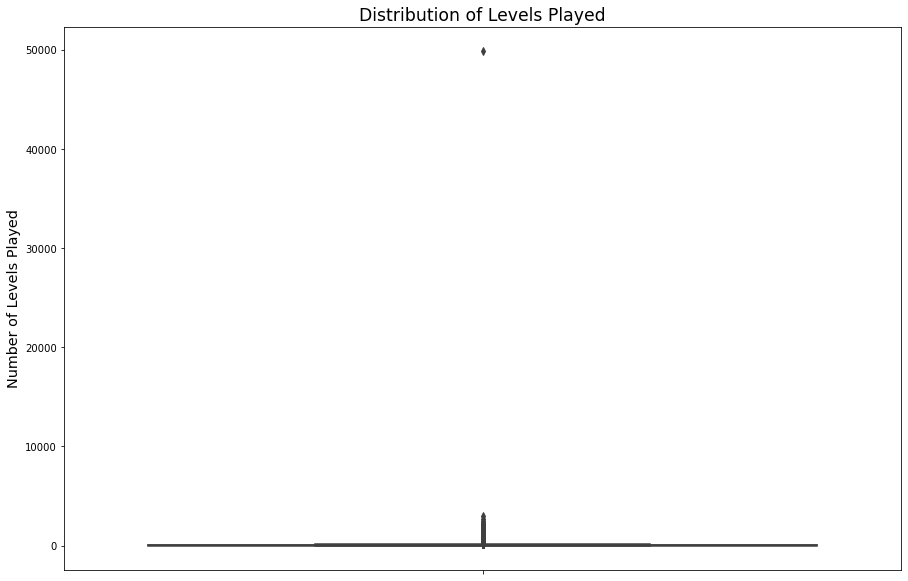

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (15,10))
sns.boxplot(y='sum_gamerounds', data=cats, ax=ax)
ax.set_ylabel('Number of Levels Played', fontdict={'fontsize':'x-large'})
ax.set_title('Distribution of Levels Played', fontdict={'fontsize':'xx-large'})
plt.show()

It appears that one outlier is causing the high max for sum_gamerounds. Because we are fairly sure this is an erroneous value, we can drop it from the data.

In [7]:
cats = cats[cats['sum_gamerounds'] < cats['sum_gamerounds'].max()]

Now let's view the summary statistics and boxplots for the data without the extreme value.

In [8]:
cats['sum_gamerounds'].describe()

count   90188.00
mean       51.32
std       102.68
min         0.00
25%         5.00
50%        16.00
75%        51.00
max      2961.00
Name: sum_gamerounds, dtype: float64

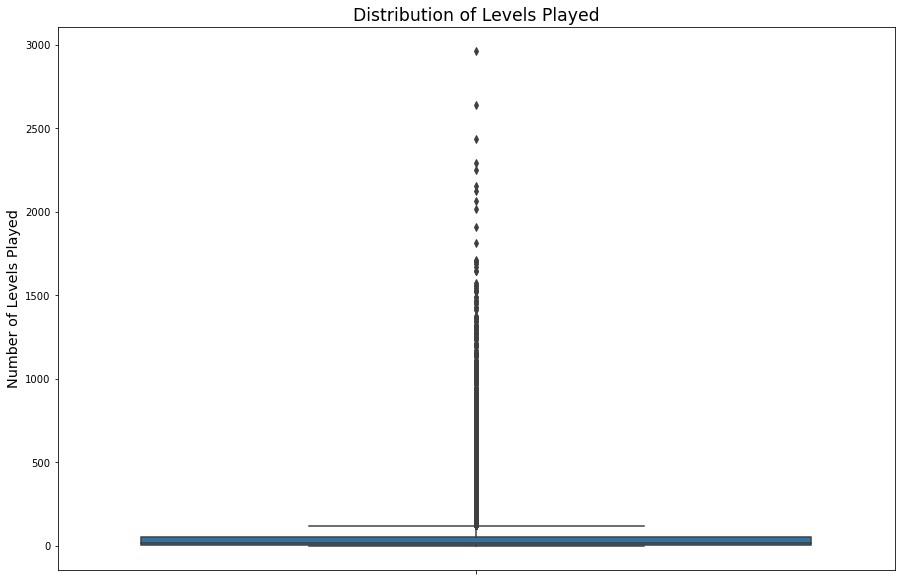

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (15,10))
sns.boxplot(y='sum_gamerounds', data=cats, ax=ax)
ax.set_ylabel('Number of Levels Played', fontdict={'fontsize':'x-large'})
ax.set_title('Distribution of Levels Played', fontdict={'fontsize':'xx-large'})
plt.show()

The data is still very right-skewed. Some players played well above 1,000 or even 2,000 levels, but the majority of players played a relatively small number of levels.

To better see the distribution of users who played only a small number of levels, let's plot a histogram of the number users who played each number of levels. We'll show all levels on one histogram and just the first 100 levels on another histogram.

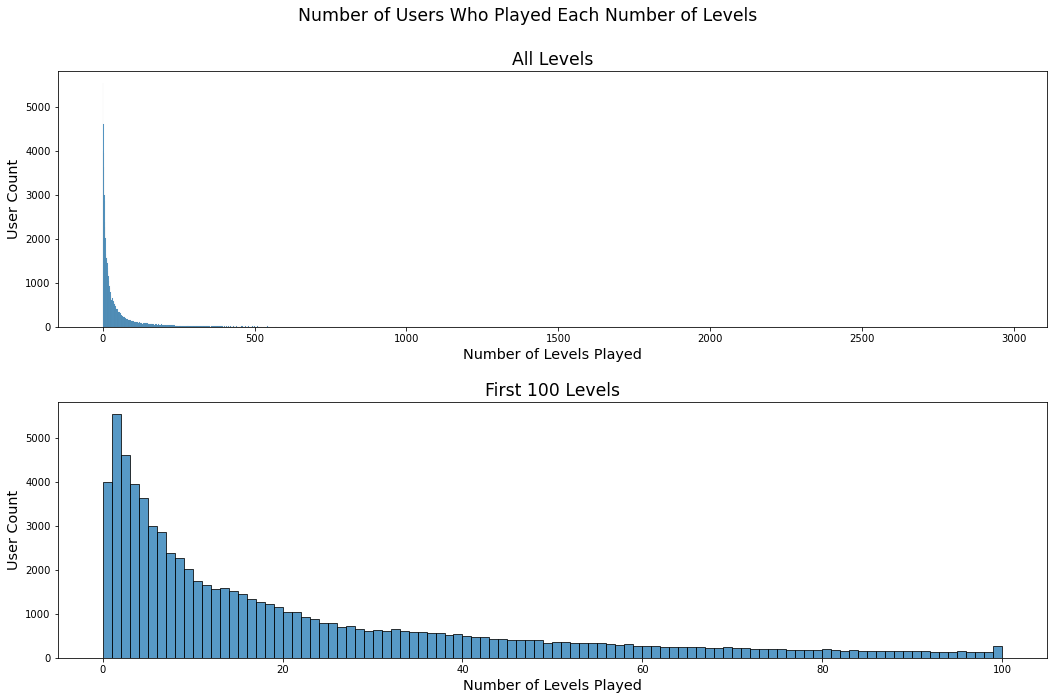

In [10]:
fig, axes = plt.subplots(2, 1, figsize = (15,10))
sns.histplot(x='sum_gamerounds', data=cats, binwidth=1, ax=axes[0])
sns.histplot(x='sum_gamerounds', data=cats[cats['sum_gamerounds'] <= 100], binwidth=1, ax=axes[1])
plt.suptitle('Number of Users Who Played Each Number of Levels', fontsize='xx-large')
axes[0].set_title('All Levels', fontdict={'fontsize':'xx-large'})
axes[1].set_title('First 100 Levels', fontdict={'fontsize':'xx-large'})
axes[0].set_xlabel('Number of Levels Played', fontdict={'fontsize':'x-large'})
axes[1].set_xlabel('Number of Levels Played', fontdict={'fontsize':'x-large'})
axes[0].set_ylabel('User Count', fontdict={'fontsize':'x-large'})
axes[1].set_ylabel('User Count', fontdict={'fontsize':'x-large'})
plt.tight_layout(pad=2)
plt.show()

We observe that almost 4,000 users didn't play any levels after installing Cookie Cats. Why might this be so? Some possible reasons include:

* They opened the game and didn't like what they saw (e.g., design, interface, colors, music, etc) and quit before playing any levels.
* They opened the game and wanted to play but could not figure out how to play.
* They still intend to play but have not had time yet.
* They downloaded other apps at the same time and decided to play those instead.

It is also worth noting that even more users stopped playing the game after only playing one or two levels. Some possible reasons for this include:

* The game was too easy and they got bored.
* The game was too difficult and they got frustrated.
* The game was too difficult and they simply could not advance to more levels.
* They decided they did not enjoy playing the game regardless of difficulty.
* The game turned out to be different than they expected.

Tactile Entertainment should try to figure out why so many users are churning early on, but that question is beyond the scope of the data we have here. A survey of users, or other data collected in the game, might help to figure this out.

However, we can look at how the placement of gates affects retention for users who make it to later levels. Let's turn now to the retention data.

## IV. Comparing One-Day Retention Between Groups

Let's first look at the percentage of users who returned to the game one day after installing.

In [11]:
print(round(cats['retention_1'].sum()/cats['retention_1'].count()*100, 2))

44.52


About 44.52% of users return one day after installing. How does this differ between version groups?

In [12]:
ret_1_pcts = cats.groupby('version')['retention_1'].mean()*100
ret_1_pcts

version
gate_30   44.82
gate_40   44.23
Name: retention_1, dtype: float64

A higher percentage of users return to the game after one day when the gate is placed at level 30 versus when the gate is placed at level 40. From these values, we can compute a test statistic that is the percentage difference between the one-day retention rates of these two groups.

In [13]:
test_stat_1 = (ret_1_pcts[0] - ret_1_pcts[1])/ret_1_pcts[1]*100
print(round(test_stat_1, 2))

1.34


So, the retention rate for the gate_30 group is 1.34% higher than the retention rate for the gate_40 group. 

Is this difference statistically significant? We can figure this out by running a hypothesis test between the two groups. We start with a null hypothesis (e.g., that the percentage difference in one-day retention rates between groups is zero) and an alternative hypothesis (e.g., that the percentage difference is greater than zero). Generally, hypothesis tests compare the observed value $\hat{τ}$ of a test statistic $τ$ with the distribution of that test statistic if the null hypothesis were true. The null hypothesis is rejected if $\hat{τ}$ is sufficiently extreme compared to the null distribution for the chosen significance level $α$. We can measure this with a p-value. When performing a hypothesis test at significance level $α$ that rejects the null hypothesis when $\hatτ$ is in the upper tail of the null distribution, the p-value of $\hat{τ}$ is $p(\hat{τ}) = 1 − F(\hat{τ})$, where $F(τ)$ is the cumulative distribution function of $τ$ under the null hypothesis. In situations where $F(τ)$ is known, it is easy to simply calculate the p-value. However, in many situations $F(τ)$ is not known [1].

If we were sure that the distribution of $τ$ (in our case, the percent difference in one-day retention rates) were normal, we could use a parametric test like a t test. However, we are not sure what the distribution of $τ$ is, so a non-parametric test would be more appropriate. One such test is a permutation test. With a permutation test, we pool our two groups of data and generate a new data set of every possible permuation of the labels in groups A and B (in our case, the gate_30 group and the gate_40 group). We then take a random sample, indexed by $j$, from this set of permuted data without replacement and compute our test statistic $τ^{*}_{j}$ for each permuted sample we draw. The result is the empirical distribution function $\hat{F}^{∗}$ of the test statistic $τ^{*}_{j}$ under the null hypothesis, and it can be used to perform hypothesis tests [2]. Under this process, the p-value for the upper tail is: 

$$\hat{p}^{*}(\hat{τ}) = 1 - \hat{F}^{∗}(\hatτ) = \frac{1}{B}\sum \limits _{j=1} ^{B} I(τ^{*}_{j} > \hat{τ})$$

where $I(·)$ is the indicator function, which is equal to 1 when its argument is true and 0 otherwise. This is the same as measuring the proportion of test statistics computed from samples of permuted data that exceed the observed value $\hat{τ}$.

While a one-tailed test works if we are measuring the possibility of an effect only in one direction, a two-tailed hypothesis test is necessary if we are measuring the possibility of an effect in either direction. Performing a two-tailed hypothesis test requires different formulas for p-values. Assuming that $τ$ is symmetrically distributed around 0, then the symmetric p-value is appropriate:

$$\hat{p}_{s}^{*}(\hat{τ}) = \frac{1}{B}\sum \limits _{j=1} ^{B} I(|τ^{*}_{j}| > |\hat{τ}|)$$

If assuming a symmetric distribution of $τ$ is not possible, then the equal-tail p-value is appropriate:

$$\hat{p}_{et}^{*}(\hat{τ}) = 2 * min(\frac{1}{B}\sum \limits _{j=1} ^{B} I(τ^{*}_{j} \leq \hat{τ}), \frac{1}{B}\sum \limits _{j=1} ^{B} I(τ^{*}_{j} > \hat{τ}))$$

This is just the lesser of the upper and lower tail p-values multiplied by 2 [1].

A permutation test is more flexible than a t test because it only relies on the assumption that the labels in our data are exchangeable. A sequence of random variables is exchangeable if any permutation of that sequence has the same joint probability distribution as the original. For example, a coin has a 50% chance of coming up heads and 50% chance of coming up tails. Any permutation of a series of flips with this coin will still have the same joint probability distribution because the process generating all the data is the same. Likewise, even if the coin had a 60% chance of coming up heads and 40% chance of coming up tails, the resulting sequence of coin flips would still be exchangeable. However, a series of coin flips that alternated between these two coins would not be exchangeable because the data generating process changes between coin flips [3].

Because players in our data were randomly assigned to either group, which is essentially the same as a series of coin flips with the same coin, our data meets the assumption of exchangeability, so we can perform a permutation test. We will test the null hypothesis that the percentage difference between the one-day retention rate for the gate_30 group and the one-day retention rate for the gate_40 group is zero at a significance level of $α = 5\%$. The alternative hypothesis is that this percentage difference is not zero, because we are still not sure if moving the gate has a positive or negative effect on retention and we would like to account for all possibilities. Thus, we should use a two-tailed test. We cannot assume that the distribution of this test statistic is symmetric around zero, so we will use the equal-tail p-value.

In [14]:
#Randomly sample 5000 permutations of length equal to both groups of data
len_30, len_40 = len(cats[cats['version'] == 'gate_30']), len(cats[cats['version'] == 'gate_40'])
perm = np.array([np.random.permutation(len_30 + len_40) for i in range(5000)])

#Pool data and assign permutations
ret_1 = np.array(cats['retention_1'])
perm_30_1 = ret_1[perm[:, :len_30]]
perm_40_1 = ret_1[perm[:, len_30:]]

#Compute test statistics for each permutation
pct_diffs_1 = (np.mean(perm_30_1, axis=1) - np.mean(perm_40_1, axis=1))/np.mean(perm_40_1, axis=1)*100

#Compute p-value
p = 2*np.minimum(np.sum(pct_diffs_1 <= test_stat_1)/5000, np.sum(pct_diffs_1 > test_stat_1)/5000)
print(f'p-value = {round(p, 2)}')

p-value = 0.06


The p-value of 0.06 is greater than the significance level of 0.05, so we fail to reject the null hypothesis that the gate_30 and gate_40 groups have different one-day retention rates. 

Another way to see this is to plot the null distribution of the test statistic in a histogram and see where the actual percent difference in retention falls in that distribution. For a significance level of 5%, if the actual value of the test statistic falls within the 95% confidence interval of the null distribution, then we fail to reject the null hypothesis.

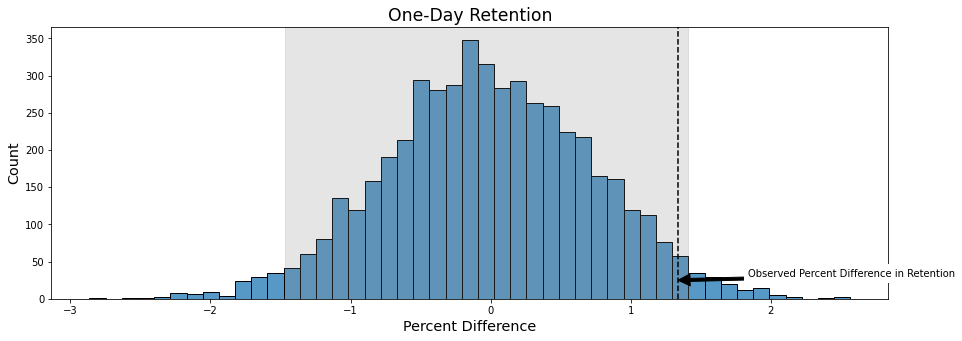

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=pct_diffs_1, ax=ax)
ax.set_xlabel('Percent Difference', fontdict={'fontsize':'x-large'})
ax.set_ylabel('Count', fontdict={'fontsize':'x-large'})
ax.set_title('One-Day Retention', fontdict={'fontsize':'xx-large'})

#Plot 95% confidence interval
lower, upper = np.percentile(pct_diffs_1, [2.5, 97.5])
plt.axvspan(lower, upper, color='grey', alpha=0.2)

#Plot line at observed value of test statistic
plt.axvline(x = test_stat_1, linestyle='--', color='black')
plt.annotate('Observed Percent Difference in Retention', xy=(test_stat_1, 25),
             xytext=(test_stat_1 + 0.5, 30), arrowprops={'facecolor':'black', 'width':3},
             backgroundcolor ='white')
plt.show()

It isn't too surprising that we would fail to reject the null hypothesis that the one-day retention rate is different when the gate is placed at level 30 versus level 40. If players have only been playing the game for one day, it is likely that most players have not yet reached round 30. Thus, we should also perform a similar test using the seven-day retention rate to see if the gate placement makes any difference in retention.

## V. Comparing Seven-Day Retention Between Groups

First, we calculate the overall seven-day retention rate.

In [16]:
print(round(cats['retention_7'].sum()/cats['retention_7'].count()*100, 2))

18.61


The seven-day retention rate is about 18.61%, which is much lower than the one-day retention rate. This indicates that much fewer people are playing the game a week after installing versus one day after installing. How does the retention rate differ between version groups?

In [17]:
ret_7_pcts = cats.groupby('version')['retention_7'].mean()*100
ret_7_pcts

version
gate_30   19.02
gate_40   18.20
Name: retention_7, dtype: float64

Once again, the retention rate is higher when the gate is placed at level 30 versus when the gate is placed at level 40, by an even larger amount. Let's compute the percentage difference between the retention rates of these two groups.

In [18]:
test_stat_7 = (ret_7_pcts[0] - ret_7_pcts[1])/ret_7_pcts[1]*100
print(round(test_stat_7, 2))

4.5


This is a much larger percentage difference in retention rates (about 4.5%) than we saw with the one-day retention rates. Presumably, this is because more players have had a chance to get to the gate after seven days than after just one day.

As we did with the percentage difference in one-day retention rates, let's perform a two-tailed permutation test at the 5% significance level to determine whether this difference in retention rates is statistically significant.

In [19]:
#Pool data and assign permutations
ret_7 = np.array(cats['retention_7'])
perm_30_7 = ret_7[perm[:, :len_30]]
perm_40_7 = ret_7[perm[:, len_30:]]

#Compute test statistics for each permutation
pct_diffs_7 = (np.mean(perm_30_7, axis=1) - np.mean(perm_40_7, axis=1))/np.mean(perm_40_7, axis=1)*100

#Compute p-value
p = 2*np.minimum(np.sum(pct_diffs_7 >= test_stat_7)/5000, np.sum(pct_diffs_7 < test_stat_7)/5000)
print(f'p-value = {round(p, 2)}')

p-value = 0.0


The p-value now is much lower than 0.05, so we reject the null hypothesis that the percentage difference in seven-day retention rates for the two groups is zero. Again, we can visualize this with a histogram.

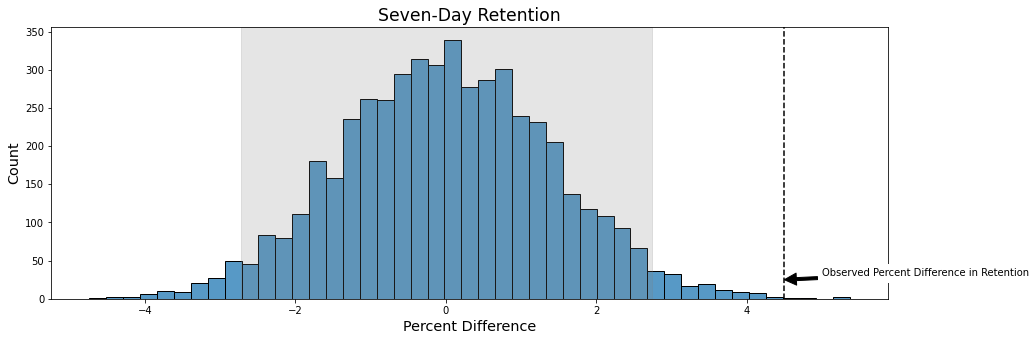

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=pct_diffs_7, ax=ax)
ax.set_xlabel('Percent Difference', fontdict={'fontsize':'x-large'})
ax.set_ylabel('Count', fontdict={'fontsize':'x-large'})
ax.set_title('Seven-Day Retention', fontdict={'fontsize':'xx-large'})

#Plot 95% confidence interval
lower, upper = np.percentile(pct_diffs_7, [2.5, 97.5])
plt.axvspan(lower, upper, color='grey', alpha=0.2)

#Plot line at observed value of test statistic
plt.axvline(x = test_stat_7, linestyle='--', color='black')
plt.annotate('Observed Percent Difference in Retention', xy=(test_stat_7, 25),
             xytext=(test_stat_7 + 0.5, 30), arrowprops={'facecolor':'black', 'width':3},
             backgroundcolor ='white')
plt.show()

Here, unlike with the one-day retention rate, the actual percentage difference in seven-day retention rates is well outside of the 95% confidence interval.

## VI. Discussion and Conclusion

Our A/B test indicates that there is strong evidence that the seven-day retention rate is higher when the gate is placed in level 30 than in level 40. But why is this so? Wouldn't we expect placing an obstacle earlier in the game to reduce retention? Not necessarily. This could be an example of hedonic adaptation, which is an observed tendency of people to quickly revert back to a stable level of happiness after positive or negative events [4]. It is possible that by placing a gate earlier in the game, the game forces players to take a break, which keeps them from getting bored with the game and prolongs their enjoyment. 

As a follow-up to this test, it would be useful to look at whether placing the gate even earlier in the game (e.g., at round 20 or 25) increases the retention rate even more. It would also be useful to do a survey of users or use other data from the game to determine why so many users churn in the first few levels of the game. Figuring this out and then resolving the problem could have a much larger overall effect on player retention.

## VII. References

1. MacKinnon JG. 2007 'Bootstrap Hypothesis Testing'. Queen’s Economics Department Working Paper No. 1127. https://ageconsearch.umn.edu/record/273603/files/qed_wp_1127.pdf.
2. DataCamp. 'Permutation testing'. Statistical Simulation in Python. https://campus.datacamp.com/courses/statistical-simulation-in-python/resampling-methods?ex=11.
3. Berk M. September 21, 2021, 'How to use Permutation Tests'. Towards Data Science. https://towardsdatascience.com/how-to-use-permutation-tests-bacc79f45749.
4. 'Hedonic Treadmill'. Wikipedia. https://en.wikipedia.org/wiki/Hedonic_treadmill.